# Bird Species Classification Using 3 seconds Spectrograms and MobileNETV2

This notebook trains a deep learning model to classify bird species based on spectrogram images of their vocalizations. Using a MobileNetV2 architecture pre-trained on ImageNet, we fine-tune the model on BIRDeep dataset of bird vocalizations. The trained model is used for inference, generating structured CSV outputs with predicted species for segmented test audio recordings.

## Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Metric, F1Score
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, f1_score

2025-02-21 19:46:15.329654: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

No GPU found


## Constants and Hyperparameters

In [3]:
EXPERIMENT = "MobileNetV2"

In [4]:
# Dataset Folders
TRAIN_FOLDER = "../../../Data/Dataset/images/For Classifier/train/"
VALIDATION_FOLDER = "../../../Data/Dataset/images/For Classifier/validation/"
TEST_FOLDER = "../../../Data/Dataset/images/For Classifier/test/"
BSD_TEST_FOLDER = "../../../Data/Dataset/images/For Classifier/BirdSongDetectorTestSegments/"

In [5]:
# check number of subfolders in train
print("Number of classes in Train folder: ", len(os.listdir(TRAIN_FOLDER)))

Number of classes in Train folder:  29


In [6]:
# Preprocesamiento
BATCH_SIZE = 16

TARGET_IMG_WIDTH = 224
TARGET_IMG_HEIGHT = 224
TARGET_IMG_CHANNELS = 3
TARGET_SIZE = [TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT]
TARGET_SHAPE = [TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT, TARGET_IMG_CHANNELS]

NUM_CLASSES = len(os.listdir(TRAIN_FOLDER))

# metrics and checkpoint, macro metrics
CHECKPOINT_MONITOR = "val_accuracy"
CHECKPOINT_MODE = 'max'
METRICS = ["accuracy"]


EARLYSTOP_MONITOR = 'val_accuracy'
EARLYSTOP_MODE = 'val_accuracy'
EARLYSTOP_PATIENCE = 7

# LR_MONITOR = 'val_loss'
# LR_FACTOR = 0.5
# LR_PATIENCE = 5
# LR_MINLR = 0.0001

INITIAL_WEIGHTS = 'imagenet'

# Train
OPTIMIZER = "adam"
# LOSS = 'sparse_categorical_crossentropy'
LOSS = SparseCategoricalCrossentropy()

NUM_EPOCHS = 50

## Dataset visualization and preprocessing

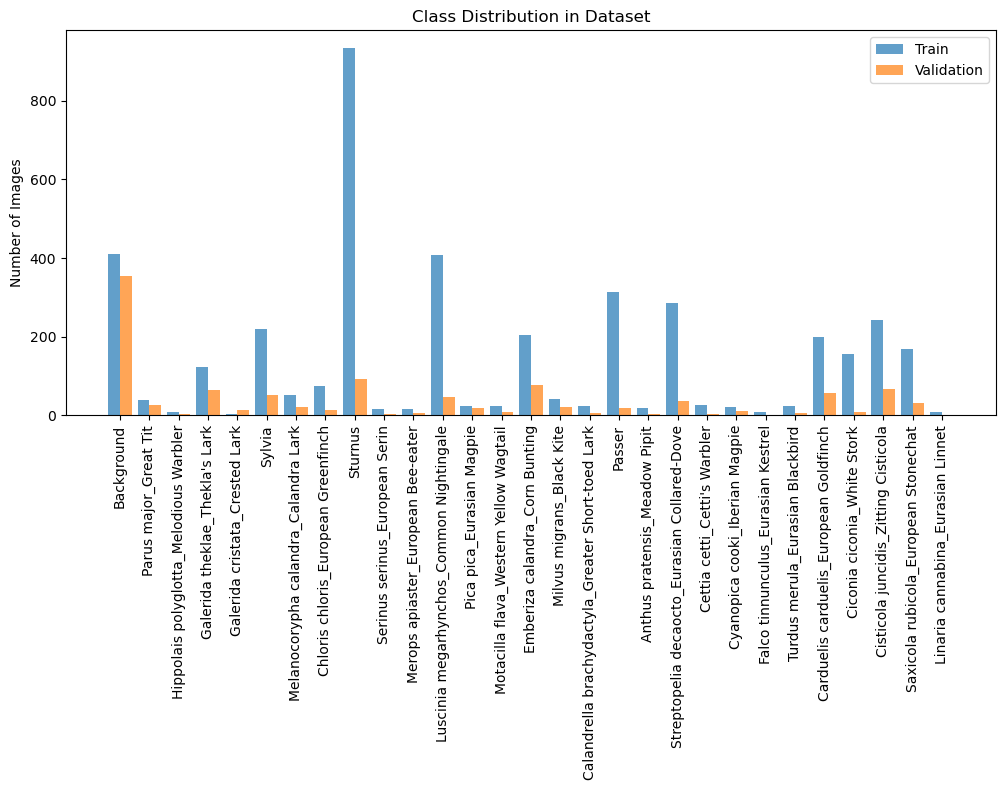

In [7]:
# Data visualization: Count images per class
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images_per_class(TRAIN_FOLDER)
val_counts = count_images_per_class(VALIDATION_FOLDER)

# Plot class distribution without stacking bars
plt.figure(figsize=(12, 5))
width = 0.4  # the width of the bars
train_positions = np.arange(len(train_counts))
val_positions = train_positions + width

plt.bar(train_positions, train_counts.values(), width=width, color='C0', alpha=0.7, label='Train')
plt.bar(val_positions, val_counts.values(), width=width, color='C1', alpha=0.7, label='Validation')

plt.xticks(train_positions + width / 2, train_counts.keys(), rotation=90)
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.legend()
plt.show()

In [8]:
hsv_h= 0.015
hsv_s= 0.2
hsv_v= 0.2

def augment_image(img):
    img = tf.image.random_hue(img, hsv_h)
    img = tf.image.random_saturation(img, 1-hsv_s, 1+hsv_s)
    img = tf.image.random_brightness(img, hsv_v)
    return img

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=1.0,
    preprocessing_function=augment_image,
)

train_dataset = datagen.flow_from_directory(
    TRAIN_FOLDER,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_FOLDER, 
    batch_size=BATCH_SIZE, 
    image_size=TARGET_SIZE, 
    label_mode='int',
    shuffle=True,
)

Found 4080 images belonging to 29 classes.
Found 1061 files belonging to 29 classes.


In [9]:
# # image to augment, the same image is augmented 4 times
# image = next(iter(train_dataset.take(1)))[0][1]

# # take random image and apply maximum values of each augmentations, above each image, the augmentation and value
# hsv_s= 0.7
# hsv_v= 0.4

# plt.figure(figsize=(10, 10))

# ax = plt.subplot(1, 5, 1)
# plt.imshow(image.numpy().astype("uint8"))
# plt.axis("off")
# plt.title("Original")

# # Plot the augmented images
# # 1- width_shift_range = 1.0
# ax = plt.subplot(1, 5, 2)
# augmented = augment_image(image)
# plt.imshow(augmented.numpy().astype("uint8"))
# plt.axis("off")
# plt.title("Augmented image")

# # 2- hsv_h= 0.015
# ax = plt.subplot(1, 5, 3)
# # apply directly hue = 0.015
# augmented_hue = tf.image.adjust_hue(image, 0.015)
# plt.imshow(augmented_hue.numpy().astype("uint8"))
# plt.axis("off")
# plt.title("Hue = 0.015")

# # 3- hsv_s= 0.7
# ax = plt.subplot(1, 5, 4)
# augmented_saturation = tf.image.adjust_saturation(image, 1.3)
# plt.imshow(augmented_saturation.numpy().astype("uint8"))
# plt.axis("off")
# plt.title("Saturation = 0.7")

# # 4- hsv_v= 0.4
# ax = plt.subplot(1, 5, 5)
# augmented_bright = tf.image.adjust_brightness(image, 0.4)
# plt.imshow(augmented_bright.numpy().astype("uint8"))
# plt.axis("off")
# plt.title("Brightness = 0.4")

# plt.show()

## MobileNetV2 Model

### Load model

Pretrained with ImageNet weights and freeze all layers except the last one to do two training steps: first, train the last layers, and then train the whole model.

In [10]:
# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

In [12]:
# Compile model
model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,593,373 (9.89 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Callbacks configuration

In [14]:
model_save_path = f"../../models/DeepLearningModels/{EXPERIMENT}/"

# if model save path does not exist, create it
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

In [15]:
# Definir Early Stopping
early_stopping = EarlyStopping(
    monitor=EARLYSTOP_MONITOR,
    mode=EARLYSTOP_MODE,
    patience=EARLYSTOP_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

# callback ModelCheckpoint
checkpoint = ModelCheckpoint(
    model_save_path + "best_model.keras",
    monitor=CHECKPOINT_MONITOR,
    mode=CHECKPOINT_MODE,
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

csv_logger = CSVLogger(
    model_save_path + "training_log.csv", 
    append=True
)


# Definir ReduceLROnPlateau
# Politicas de LR
# reduce_lr = ReduceLROnPlateau(
#     monitor=LR_MONITOR,
#     factor=LR_FACTOR,
#     patience=LR_PATIENCE,
#     # min_lr=LR_MINLR,
#     verbose = 1)
# monitor = mean_absolute_error



/tmp/ipykernel_458212/228286522.py:2: UserWarning: EarlyStopping mode val_accuracy is unknown, fallback to auto mode.
  early_stopping = EarlyStopping(


In [16]:
# Callbacks
CALLBACKS = [
    early_stopping,
    checkpoint,
    csv_logger
    # reduce_lr,
]

### Training

In [17]:
history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    callbacks=CALLBACKS)

/home/gruncrow/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.3697 - loss: 2.2786
Epoch 1: val_accuracy improved from -inf to 0.12630, saving model to ../../models/DeepLearningModels/MobileNetV2/best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 119s 455ms/step - accuracy: 0.3699 - loss: 2.2777 - val_accuracy: 0.1263 - val_loss: 3.4997
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.4661 - loss: 1.7361
Epoch 2: val_accuracy did not improve from 0.12630
255/255 ━━━━━━━━━━━━━━━━━━━━ 108s 423ms/step - accuracy: 0.4661 - loss: 1.7361 - val_accuracy: 0.0716 - val_loss: 3.8288
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.4841 - loss: 1.5974
Epoch 3: val_accuracy did not improve from 0.12630
255/255 ━━━━━━━━━━━━━━━━━━━━ 107s 421ms/step - accuracy: 0.4841 - loss: 1.5974 - val_accuracy: 0.0254 - val_loss: 4.0721
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.4940 - loss: 1.5186
Epoch 4: val_accuracy did not improve from 0.12630
25

### Validation evaluation

In [21]:
# Evaluate model with validation
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.1898 - loss: 4.8228
Validation Loss: 4.781278133392334, Validation Accuracy: 0.19698397815227509


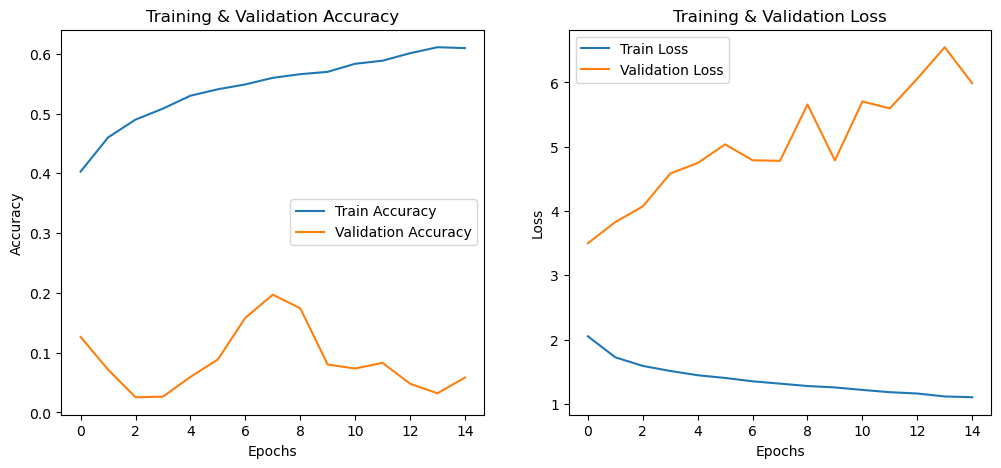

In [23]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [24]:
y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_pred = np.argmax(model.predict(val_dataset), axis=1)
print(classification_report(y_true, y_pred, target_names=val_dataset.class_names))

2025-02-21 20:31:10.349901: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 247ms/step
                                                   precision    recall  f1-score   support

                    Anthus pratensis_Meadow Pipit       0.00      0.00      0.00         3
                                       Background       0.32      0.73      0.45       353
Calandrella brachydactyla_Greater Short-toed Lark       0.00      0.00      0.00         5
           Carduelis carduelis_European Goldfinch       0.07      0.28      0.11        57
                     Cettia cetti_Cetti's Warbler       0.00      0.00      0.00         3
              Chloris chloris_European Greenfinch       0.00      0.00      0.00        14
                      Ciconia ciconia_White Stork       0.00      0.00      0.00         9
             Cisticola juncidis_Zitting Cisticola       0.00      0.00      0.00        66
                   Cyanopica cooki_Iberian Magpie       0.00      0.00      0.00        11
                   Emberiza calandra_Corn Bunti

/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Re-training the model

In [25]:
# Make model trainable
model.trainable = True

In [26]:
# Train model
history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    callbacks=CALLBACKS)

Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5855 - loss: 1.2428
Epoch 1: val_accuracy did not improve from 0.19698
255/255 ━━━━━━━━━━━━━━━━━━━━ 188s 737ms/step - accuracy: 0.5855 - loss: 1.2430 - val_accuracy: 0.0716 - val_loss: 4.7040
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.5781 - loss: 1.2424
Epoch 2: val_accuracy did not improve from 0.19698
255/255 ━━━━━━━━━━━━━━━━━━━━ 182s 715ms/step - accuracy: 0.5781 - loss: 1.2425 - val_accuracy: 0.1791 - val_loss: 4.8972
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.5957 - loss: 1.1949
Epoch 3: val_accuracy did not improve from 0.19698
255/255 ━━━━━━━━━━━━━━━━━━━━ 183s 717ms/step - accuracy: 0.5957 - loss: 1.1950 - val_accuracy: 0.0518 - val_loss: 6.0701
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.6071 - loss: 1.1535
Epoch 4: val_accuracy did not improve from 0.19698
255/255 ━━━━━━━━━━━━━━━━━━━━ 183s 716ms/step - accuracy: 0.6071 - loss: 1.1537 - 

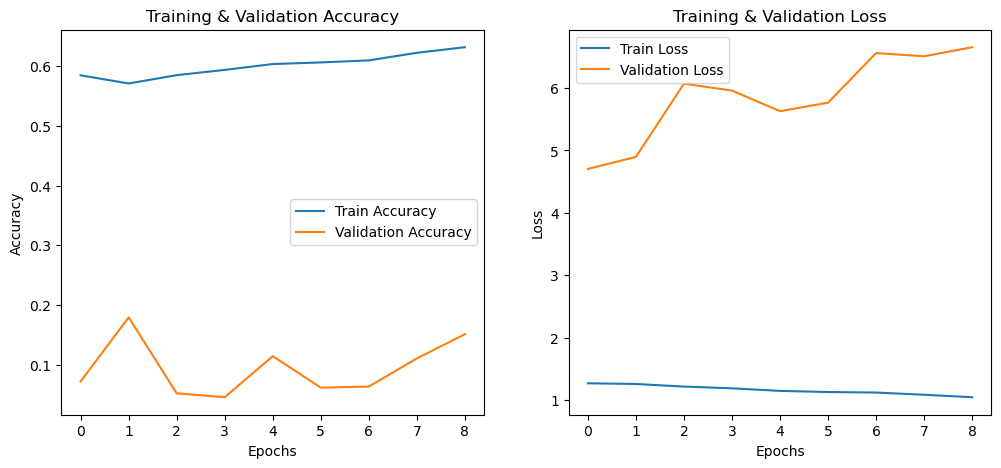

In [27]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [28]:
# Evaluate model with validation
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_pred = np.argmax(model.predict(val_dataset), axis=1)
print(classification_report(y_true, y_pred, target_names=val_dataset.class_names))

67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 252ms/step - accuracy: 0.1733 - loss: 4.9906
Validation Loss: 4.897215366363525, Validation Accuracy: 0.17907634377479553
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step
                                                   precision    recall  f1-score   support

                    Anthus pratensis_Meadow Pipit       0.00      0.00      0.00         3
                                       Background       0.32      0.65      0.43       353
Calandrella brachydactyla_Greater Short-toed Lark       0.00      0.00      0.00         5
           Carduelis carduelis_European Goldfinch       0.03      0.04      0.03        57
                     Cettia cetti_Cetti's Warbler       0.00      0.00      0.00         3
              Chloris chloris_European Greenfinch       0.00      0.00      0.00        14
                      Ciconia ciconia_White Stork       0.01      0.22      0.02         9
             Cisticola juncidis_Zitting Cisticola       0.00      0.00      

/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Inference

In [29]:
# load model
model = tf.keras.models.load_model(model_save_path + "best_model.keras")

In [30]:
# TEST_FOLDER
OUTPUT_TEST_FOLDER = f"../../Predictions/DeepLearning/{EXPERIMENT}/Test/"
OUTPUT_BDS_TEST_FOLDER = f"../../Predictions/DeepLearning/{EXPERIMENT}/BirdSongDetectorTest/"

In [31]:
import re
def extract_parts(filename):
    """Extracts the base filename and numerical suffix for proper sorting."""
    match = re.match(r'(.+?)_(\d+)\.PNG$', filename)  # Extract base name and number
    if match:
        base_name = match.group(1)  # Everything before _X
        number = int(match.group(2))  # The numeric suffix
        return (base_name, number)
    return (filename, float('inf'))  # Ensures non-matching filenames go last

In [32]:
# Inference

def predict_and_save_results(test_folder, output_test_folder, model):
    for root, _, files in os.walk(test_folder):
        predictions = []
        # sort files to ensure order
        for file in sorted(files, key=extract_parts):
            if file.endswith(".PNG"):
                # print(file)
                img_path = os.path.join(root, file)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=TARGET_SIZE)
                img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)
                pred = model.predict(img_array, verbose=0)
                class_idx = np.argmax(pred)
                class_name = list(train_counts.keys())[class_idx]
                confidence = np.max(pred)
                
                if class_name.lower() != "background":
                    start_sec = int(file.split("_")[-1].split(".")[0]) * 3
                    end_sec = start_sec + 3
                    predictions.append([start_sec, end_sec, class_name.split('_')[0], class_name.split('_')[-1], confidence])
        
            if predictions and file.split(".PNG")[0].endswith("_19"):
                # output file ir mirror directory of input file but in .csv
                # output_file = os.path.join(f"../../Predictions/DeepLearning/{EXPERIMENT}", os.path.basename(root) + ".BirdNET.results.csv")
                output_file = img_path.replace(test_folder, output_test_folder).replace("_19.PNG", ".BirdNET.results.csv")
                # if directory does not exist, create it
                if not os.path.exists(os.path.dirname(output_file)):
                    os.makedirs(os.path.dirname(output_file))
                pd.DataFrame(predictions, columns=["Start (s)", "End (s)", "Scientific name", "Common name", "Confidence"]).to_csv(output_file, index=False)

                predictions = []

In [33]:
predict_and_save_results(TEST_FOLDER, OUTPUT_TEST_FOLDER, model)

In [34]:
# Inference

def predict_and_save_results(test_folder, output_test_folder, model):
    for root, _, files in os.walk(test_folder):
        predictions = []
        # sort files to ensure order
        for file in sorted(files, key=extract_parts):
            if file.endswith(".PNG"):
                # print(file)
                img_path = os.path.join(root, file)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=TARGET_SIZE)
                img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)
                pred = model.predict(img_array, verbose=0)
                class_idx = np.argmax(pred)
                class_name = list(train_counts.keys())[class_idx]
                confidence = np.max(pred)
                
                if class_name.lower() != "background":
                    start_sec = int(file.split("_")[-1].split(".")[0]) * 3
                    end_sec = start_sec + 3
                    predictions.append([start_sec, end_sec, class_name.split('_')[0], class_name.split('_')[-1], confidence])
        
            if predictions and file.split(".PNG")[0]:
                # output file ir mirror directory of input file but in .csv
                # output_file = os.path.join(f"../../Predictions/DeepLearning/{EXPERIMENT}", os.path.basename(root) + ".BirdNET.results.csv")
                output_file = img_path.replace(test_folder, output_test_folder).replace(".PNG", ".BirdNET.results.csv")
                # if directory does not exist, create it
                if not os.path.exists(os.path.dirname(output_file)):
                    os.makedirs(os.path.dirname(output_file))
                pd.DataFrame(predictions, columns=["Start (s)", "End (s)", "Scientific name", "Common name", "Confidence"]).to_csv(output_file, index=False)

                predictions = []

In [35]:
predict_and_save_results(BSD_TEST_FOLDER, OUTPUT_BDS_TEST_FOLDER, model)